In [1]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, cv2, os, random

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization

In [2]:
train_dataset = 'dataset/training/' 
test_dataset = 'dataset/testing/'

We now need to preprocess images within each folder and label them according to their classification.

In [3]:
def preprocess_image(img_path):
    # read in the image
    img = cv2.imread(img_path)

    # convert image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # normalize the image array
    img = img / 255

    # resize the image for uniformity
    img = cv2.resize(img, (500, 500))

    return img

In [9]:
def rotate_image(image, angle):
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

In [12]:
encode = {'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}
decode = {0: 'no_tumor', 1: 'meningioma_tumor', 2: 'glioma_tumor', 3: 'pituitary_tumor'}

def load_data(dataset_path):
    x_data = [] # images
    y_data = [] # labels

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        # check if the path is a directory and skip if not
        if not os.path.isdir(folder_path):
            continue  
        
        for file in os.listdir(folder_path):
            # find path of the image
            file_path = os.path.join(folder_path, file)

            # preprocess the image
            img = preprocess_image(file_path)

            # append the new image to the x array
            x_data.append(img)

            # append the label to the y array
            y_data.append(encode[folder])
            
            # apply rotation on image
            img = rotate_image(img, random.randint(-45,45))
            
            # append new data to the arrays
            x_data.append(img)
            y_data.append(encode[folder])
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # shuffle data for better training
    x_data, y_data = shuffle(x_data, y_data, random_state=101)
    
    return x_data, y_data


In [13]:
x_train, y_train = load_data(train_dataset)
x_test, y_test = load_data(test_dataset)

Let us take a look at some images within our dataset.

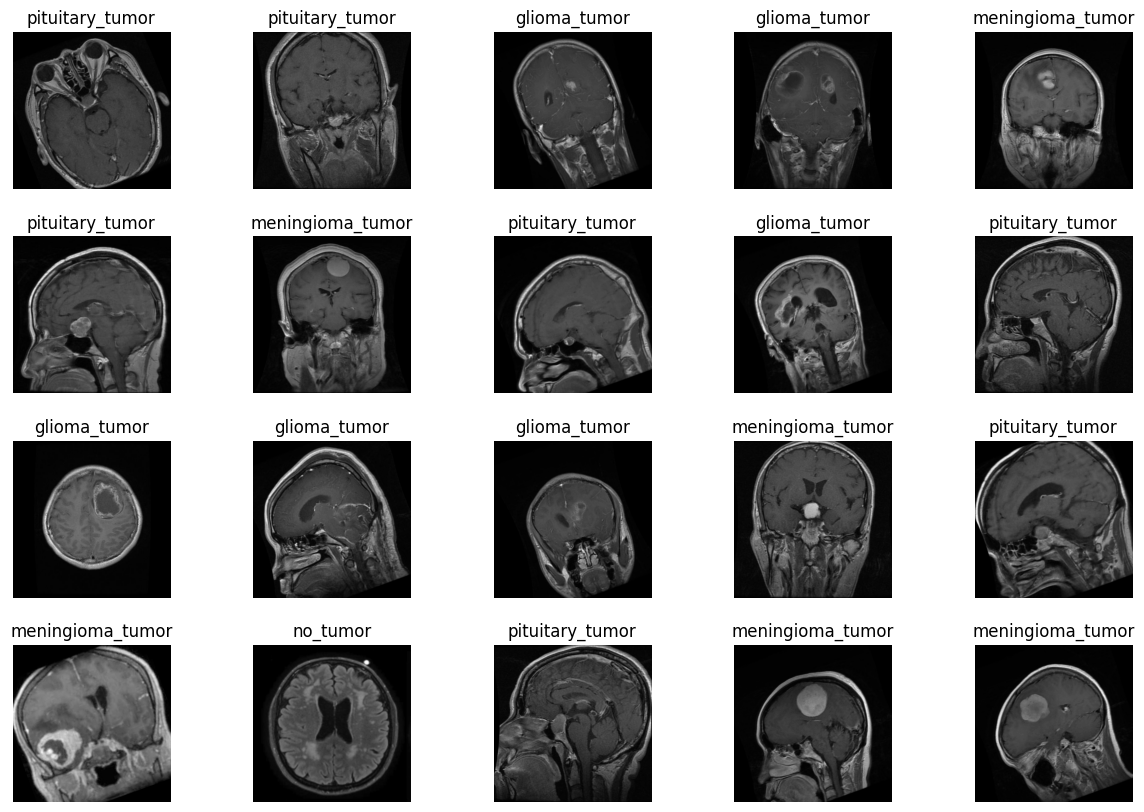

In [7]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()
for i in range(0, 20):
    index = random.randint(0, len(x_train))
    axes[i].imshow(x_train[index], cmap='gray')
    axes[i].set_title(decode[y_train[index]])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)
plt.show()

Now with our data we can create our model.

In [25]:
num_classes = len(np.unique(y_train))

def build_model(num_classes=4, input_shape=(500, 500, 1)):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5)) # Adding dropout for regularization
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for binary classification

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [26]:
def train_model(model, x_train, y_train, x_test, y_test, batch_size=0, epochs=10):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
    return history

In [27]:
model = build_model()
history = train_model(model, x_train, y_train, x_test, y_test, epochs=8)

Epoch 1/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.4744 - loss: 1.1567 - val_accuracy: 0.4873 - val_loss: 1.6220
Epoch 2/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7569 - loss: 0.5652 - val_accuracy: 0.5939 - val_loss: 1.5056
Epoch 3/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8555 - loss: 0.3727 - val_accuracy: 0.6827 - val_loss: 1.8891
Epoch 4/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9156 - loss: 0.2133 - val_accuracy: 0.6827 - val_loss: 2.3768
Epoch 5/8
26/90 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.9521 - loss: 0.1527

KeyboardInterrupt: 

With this working model, we can evaluate the model and make our observations via the following metrics.

In [22]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title('Neural Network Accuracy')
    plt.show()

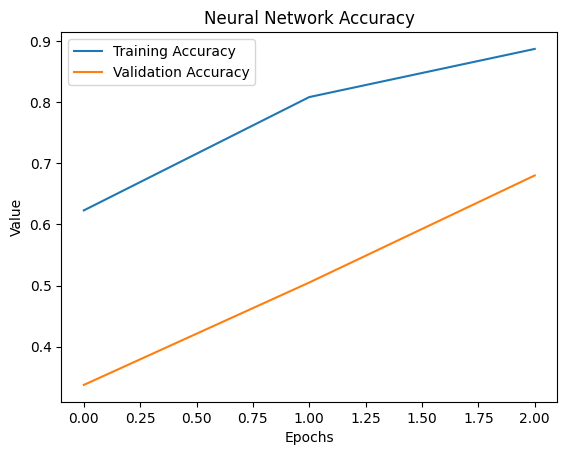

In [23]:
plot_accuracy(history)

In [12]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Neural Network Loss')
    plt.show()

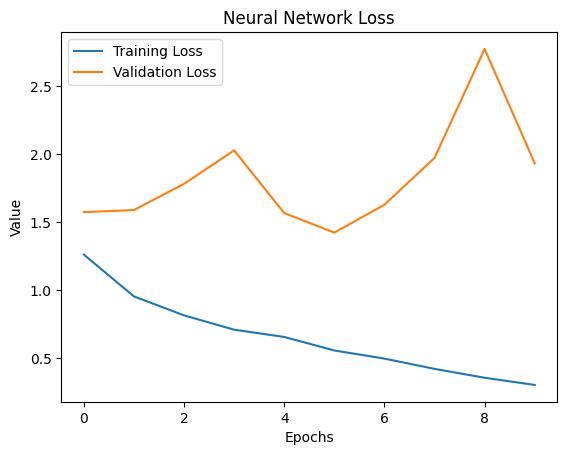

In [13]:
plot_loss(history)

In [16]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encode.keys())
    display.plot()

13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step


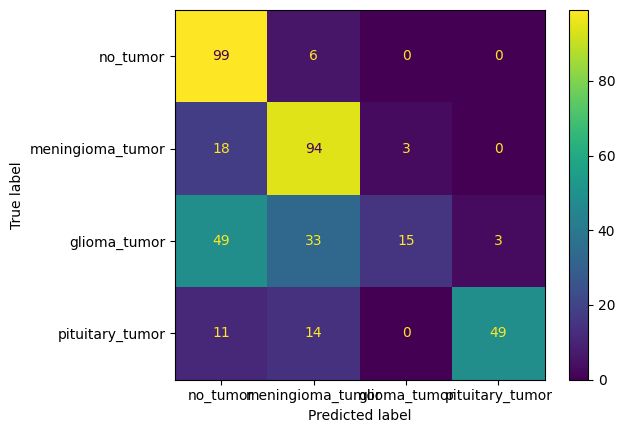

In [17]:
plot_confusion_matrix(model, x_test, y_test)

Finally, we can use our model to make predictions on images outside of our dataset with the following function.

In [18]:
# make a prediction function
def predict_image(model, img):
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    prediction = np.argmax(prediction)
    return decode[prediction]

In [20]:
predict_image(model, 'dataset/meningioma.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


'no_tumor'